In [2]:
from ase.io import read, write
import numpy as np
from matplotlib import pyplot as plt
from rascal.representations import SphericalInvariants as SOAP
from rascal.utils import radial_basis_functions_gto

In [3]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4,
              max_radial=20,
              max_angular=4,
              gaussian_sigma_constant=0.5,
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=3.5,
                            exponent=4
                        ),
              radial_basis="GTO",
              compute_gradients=False
              )
soap = SOAP(**hypers)

In [4]:
colors = ['k','grey','b','r']

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c, lw=4) for c in colors]

In [5]:
radial_hypers = hypers.copy()
radial_hypers['max_angular'] = 0
radial_hypers['max_radial'] = 20
radial_hypers['soap_type'] = "RadialSpectrum"
radial_hypers['radial_basis'] = 'GTO'
radial_soap = SOAP(**radial_hypers)

rgrid = np.linspace(0, radial_hypers['interaction_cutoff'], 100)
gto = radial_basis_functions_gto(rgrid,
                                 radial_hypers['max_radial'], radial_hypers['interaction_cutoff'])
gto.shape

(20, 100)

In [6]:
alpha = read('PI_NVT/glycine_alpha/alpha_init.xyz')
alpha.wrap(eps=1E-10)
gamma = read('PI_NVT/glycine_gamma/gamma_init.xyz')
gamma.wrap(eps=1E-10)
beta = read('PI_NVT/glycine_beta/beta_init.xyz')
beta.wrap(eps=1E-10)

In [14]:
alpha_traj = read('PI_NVT/glycine_shieldings/pi_nvt_lmp_glycine_alpha_300K_00_w_cs.xyz', ":")
for a in alpha_traj:
    a.wrap(eps=1E-10)
    a.set_array("center_atoms_mask", None)

gamma_traj = read('PI_NVT/glycine_shieldings/pi_nvt_lmp_glycine_gamma_300K_00_w_cs.xyz', ":")
for g in gamma_traj:
    g.wrap(eps=1E-10)
    g.set_array("center_atoms_mask", None)

beta_traj = read('PI_NVT/glycine_shieldings/pi_nvt_lmp_glycine_beta_300K_00_w_cs.xyz', ":")
for b in beta_traj:
    b.wrap(eps=1E-10)
    b.set_array("center_atoms_mask", None)

In [15]:
alpha_rep = soap.transform(alpha)
alpha_soaps = alpha_rep.get_features(soap)
gamma_soaps = soap.transform(gamma).get_features(soap)
beta_soaps = soap.transform(beta).get_features(soap)

In [16]:
alpha_types = np.array([f"{s}{int(i)}" for s, i in zip(alpha.symbols, alpha.arrays['shieldings'])])
beta_types = np.array([f"{s}{int(i)}" for s, i in zip(beta.symbols, beta.arrays['shieldings'])])
gamma_types = np.array([f"{s}{int(i)}" for s, i in zip(gamma.symbols, gamma.arrays['shieldings'])])

In [33]:
rcman_alpha = radial_soap.transform(alpha_traj)
rcman_beta = radial_soap.transform(beta_traj)
rcman_gamma = radial_soap.transform(gamma_traj)

In [42]:
beta_types


array(['C1', 'C1', 'C2', 'C2', 'H3', 'H3', 'H3', 'H3', 'H3', 'H3', 'H1',
       'H1', 'H2', 'H2', 'N1', 'N1', 'O1', 'O1', 'O2', 'O2'], dtype='<U2')

In [51]:
rcfeat_all = rcman_beta.get_features(radial_soap)

no_atoms = len(beta_traj[0].numbers)
rcfeat_all = rcfeat_all.reshape(len(beta_traj), no_atoms, rcfeat_all.shape[1])
rcfeat = np.mean(rcfeat_all,0)

rcfeat = rcfeat.reshape(len(beta), 4, -1)

In [44]:
i = 1

In [46]:
ji = 1

In [63]:
rcfeat[np.where(beta_types == f"H{ji}")][:, i]

array([[0.01616982, 0.02070488, 0.0488685 , 0.07704164, 0.10174904,
        0.11472776, 0.11421043, 0.10373056, 0.09145602, 0.0820879 ,
        0.07651859, 0.07260761, 0.06925545, 0.06623935, 0.06380341,
        0.06131729, 0.05735799, 0.05009628, 0.03916994, 0.02664541],
       [0.0161873 , 0.02072751, 0.04892397, 0.0771321 , 0.10187017,
        0.11486319, 0.11434198, 0.10384374, 0.09153449, 0.08209821,
        0.07641567, 0.07237001, 0.06893225, 0.06596477, 0.06374568,
        0.06156653, 0.05784053, 0.05062516, 0.03958618, 0.02690037]])

In [56]:
a = (rcfeat[np.where(gamma_types == f"H{ji}")][:, i] @ gto).T
a.shape

(100, 3)

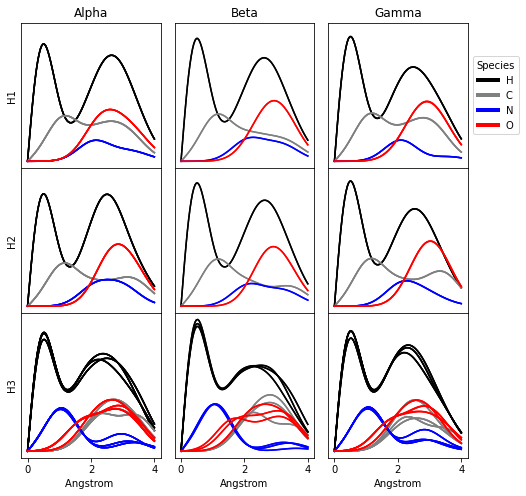

In [41]:
# g(r)


#rcman = radial_soap.transform(alpha_traj)
rcfeat_all = rcman_alpha.get_features(radial_soap)

no_atoms = len(alpha_traj[0].numbers)
rcfeat_all = rcfeat_all.reshape(len(alpha_traj), no_atoms, rcfeat_all.shape[1])
rcfeat = np.mean(rcfeat_all,0)

rcfeat = rcfeat.reshape(len(alpha), 4, -1)

fig, ax = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
for ji in range(1, 4):
    for i, s in enumerate([1, 6, 7, 8]):
        ax[ji-1][0].plot(rgrid,
                    (rcfeat[np.where(alpha_types == f"H{ji}")][:, i] @ gto).T,
                    c=colors[i],)
    ax[ji-1][0].set_yticks([])
    ax[ji-1][0].set_ylabel(f"H{ji}")
    
#rcman = radial_soap.transform(beta_traj)
rcfeat_all = rcman_beta.get_features(radial_soap)

no_atoms = len(beta_traj[0].numbers)
rcfeat_all = rcfeat_all.reshape(len(beta_traj), no_atoms, rcfeat_all.shape[1])
rcfeat = np.mean(rcfeat_all,0)


rcfeat = rcfeat.reshape(len(beta), 4, -1)

for ji in range(1, 4):
    for i, s in enumerate([1, 6, 7, 8]):
        ax[ji-1][1].plot(rgrid,
                    (rcfeat[np.where(beta_types == f"H{ji}")][:, i] @ gto).T,
                    c=colors[i],)
    
#rcman = radial_soap.transform(gamma_traj)
rcfeat_all = rcman_gamma.get_features(radial_soap)

no_atoms = len(gamma_traj[0].numbers)
rcfeat_all = rcfeat_all.reshape(len(gamma_traj), no_atoms, rcfeat_all.shape[1])
rcfeat = np.mean(rcfeat_all,0)


rcfeat = rcfeat.reshape(len(gamma), 4, -1)

for ji in range(1, 4):
    for i, s in enumerate([1, 6, 7, 8]):
        ax[ji-1][2].plot(rgrid,
                    (rcfeat[np.where(gamma_types == f"H{ji}")][:, i] @ gto).T,
                    c=colors[i],)
ax[0][-1].legend(custom_lines, ['H','C','N','O'], title='Species', loc='center left', bbox_to_anchor=(1, 0.5))
ax[0][0].set_title("Alpha")
ax[0][1].set_title("Beta")
ax[0][2].set_title("Gamma")
ax[-1][0].set_xlabel("Angstrom ")
ax[-1][1].set_xlabel("Angstrom")
ax[-1][2].set_xlabel("Angstrom")

fig.subplots_adjust(hspace=0, wspace=0.1)

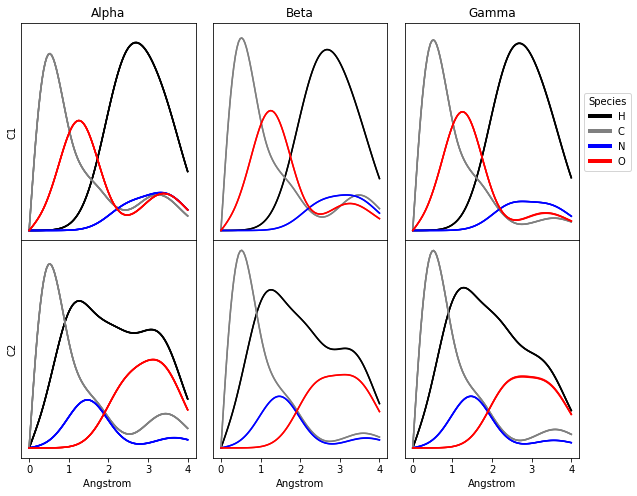

In [39]:
# g(r)

#rcman = radial_soap.transform(alpha_traj)
rcfeat_all = rcman_alpha.get_features(radial_soap)

no_atoms = len(alpha_traj[0].numbers)
rcfeat_all = rcfeat_all.reshape(len(alpha_traj), no_atoms, rcfeat_all.shape[1])
rcfeat = np.mean(rcfeat_all,0)

rcfeat = rcfeat.reshape(len(alpha), 4, -1)

fig, ax = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)
for ji in range(1, 3):
    for i, s in enumerate([1, 6, 7, 8]):
        ax[ji-1][0].plot(rgrid,
                    (rcfeat[np.where(alpha_types == f"C{ji}")][:, i] @ gto).T,
                    c=colors[i],)
    ax[ji-1][0].set_yticks([])
    ax[ji-1][0].set_ylabel(f"C{ji}")

#rcman = radial_soap.transform(beta_traj)
rcfeat_all = rcman_beta.get_features(radial_soap)

no_atoms = len(beta_traj[0].numbers)
rcfeat_all = rcfeat_all.reshape(len(beta_traj), no_atoms, rcfeat_all.shape[1])
rcfeat = np.mean(rcfeat_all,0)


rcfeat = rcfeat.reshape(len(beta), 4, -1)

for ji in range(1, 3):
    for i, s in enumerate([1, 6, 7, 8]):
        ax[ji-1][1].plot(rgrid,
                    (rcfeat[np.where(beta_types == f"C{ji}")][:, i] @ gto).T,
                    c=colors[i],)
    
#rcman = radial_soap.transform(gamma_traj)
rcfeat_all = rcman_gamma.get_features(radial_soap)

no_atoms = len(gamma_traj[0].numbers)
rcfeat_all = rcfeat_all.reshape(len(gamma_traj), no_atoms, rcfeat_all.shape[1])
rcfeat = np.mean(rcfeat_all,0)


rcfeat = rcfeat.reshape(len(gamma), 4, -1)

for ji in range(1, 3):
    for i, s in enumerate([1, 6, 7, 8]):
        ax[ji-1][2].plot(rgrid,
                    (rcfeat[np.where(gamma_types == f"C{ji}")][:, i] @ gto).T,
                    c=colors[i],)
ax[0][-1].legend(custom_lines, ['H','C','N','O'], title='Species', loc='center left', bbox_to_anchor=(1, 0.5))
ax[0][0].set_title("Alpha")
ax[0][1].set_title("Beta")
ax[0][2].set_title("Gamma")
ax[-1][0].set_xlabel("Angstrom ")
ax[-1][1].set_xlabel("Angstrom")
ax[-1][2].set_xlabel("Angstrom")

fig.subplots_adjust(hspace=0, wspace=0.1)

In [ ]:

#     ax[ji-1].set_ylabel(f"H{ji}")
# fig.subplots_adjust(hspace=0)
# fig.show()
# soap vectors -- let's not worry about this for now
# # fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
# # for i in range(1, 4):
# #     h = np.where(alpha_types==f"H{i}")[0]
# #     print(h)
# #     ax[i - 1].plot(np.mean(alpha_soaps[h], axis=0))
# #     ax[i-1].set_yticks([])
# #     ax[i-1].set_ylabel(f"H{i}")

# # ax[-1].set_xticks(
# #     np.linspace(alpha_soaps.shape[-1] // 20, 19 * alpha_soaps.shape[-1] // 20,
# #                 10))
# # ax[-1].set_xticklabels(
# #     [(a,b) for a in [1,6,7,8] for b in [1,6,7,8] if a<=b])

# # fig.subplots_adjust(hspace=0)

# # fig.show()